
# 🩺 Noninvasive Fetal ECG Extraction from Maternal Abdominal Recordings
**Dataset:** PhysioNet Challenge 2013  
**Description:**  
This notebook demonstrates preprocessing, maternal ECG suppression, source separation (ICA), 
and fetal R-peak detection for noninvasive fetal ECG monitoring.
    

In [4]:
import os
os.getcwd()


'C:\\Users\\cygni\\FINAL'

In [1]:
!pip install streamlit

In [2]:
!jupyter nbconvert --to script "BSS - FINAL (1).ipynb"

[NbConvertApp] Converting notebook BSS - FINAL (1).ipynb to script
[NbConvertApp] Writing 9646 bytes to BSS - FINAL (1).py


In [39]:
!pip install wfdb pywavelets

set-a.tar.gz already exists, skipping download.
physionet_data\set-a already extracted, skipping extraction.
✅ Found 25 records in set-a: ['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25']
Loaded record: a01, signal shape: (60000, 4)
Loaded record: a02, signal shape: (60000, 4)
Loaded record: a03, signal shape: (60000, 4)
Loaded record: a04, signal shape: (60000, 4)
Loaded record: a05, signal shape: (60000, 4)
Loaded record: a06, signal shape: (60000, 4)
Loaded record: a07, signal shape: (60000, 4)
Loaded record: a08, signal shape: (60000, 4)
Loaded record: a09, signal shape: (60000, 4)
Loaded record: a10, signal shape: (60000, 4)
Loaded record: a11, signal shape: (60000, 4)
Loaded record: a12, signal shape: (60000, 4)
Loaded record: a13, signal shape: (60000, 4)
Loaded record: a14, signal shape: (60000, 4)
Loaded record: a15, signal shape: (60000, 4)
Loaded reco

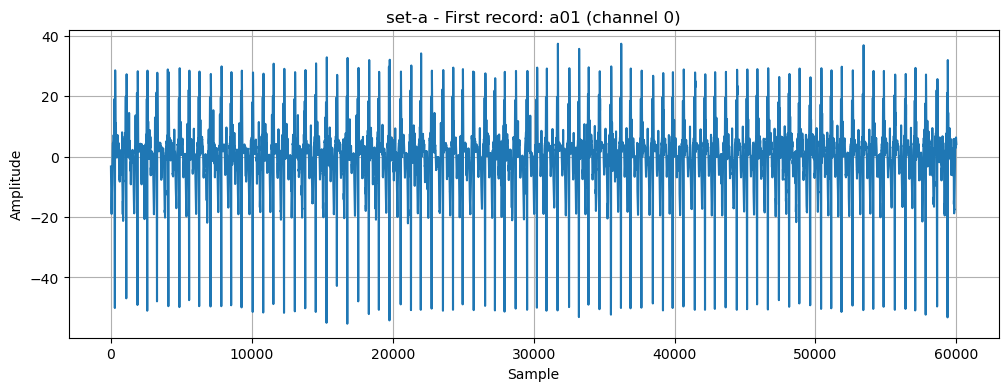

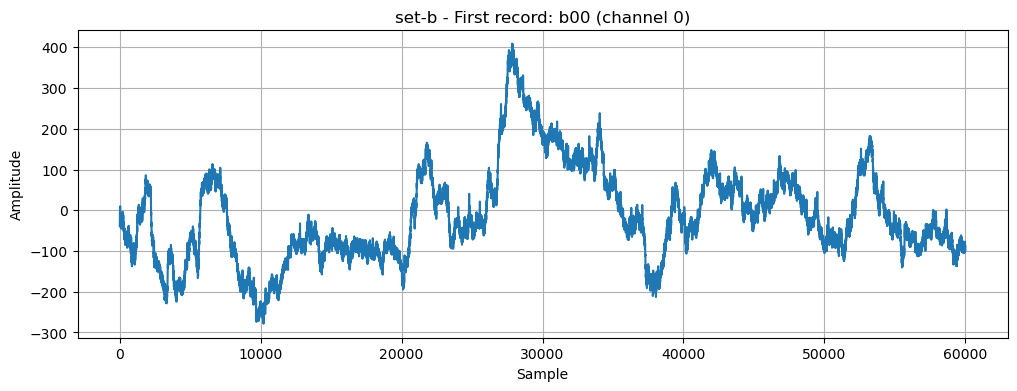

In [40]:
import os
import tarfile
import requests
import wfdb
import glob
import matplotlib.pyplot as plt

sets_info = {
    "set-a": "https://physionet.org/files/challenge-2013/1.0.0/set-a.tar.gz",
    "set-b": "https://physionet.org/files/challenge-2013/1.0.0/set-b.tar.gz"
}

base_folder = "physionet_data"

all_data = {}

for set_name, url in sets_info.items():
    archive_path = f"{set_name}.tar.gz"
    data_folder = os.path.join(base_folder, set_name)

    # Download if missing
    if not os.path.exists(archive_path):
        print(f"Downloading {archive_path}...")
        response = requests.get(url, stream=True)
        with open(archive_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("✅ Download complete!")
    else:
        print(f"{archive_path} already exists, skipping download.")

    # Extract if folder missing
    if not os.path.exists(data_folder):
        print(f"Extracting {archive_path}...")
        os.makedirs(data_folder, exist_ok=True)
        with tarfile.open(archive_path, "r:gz") as tar:
            # Use filter to allow all files, avoids DeprecationWarning in Python 3.14+
            tar.extractall(path=data_folder, filter=lambda x: x)
        print("✅ Extraction complete!")
    else:
        print(f"{data_folder} already extracted, skipping extraction.")

    hea_files = glob.glob(os.path.join(data_folder, "**/*.hea"), recursive=True)

    if not hea_files:
        print(f"❌ No records found in {data_folder}!")
        all_data[set_name] = []
        continue

    record_names = [os.path.splitext(os.path.basename(f))[0] for f in hea_files]
    print(f"✅ Found {len(hea_files)} records in {set_name}: {record_names}")

    records_list = []
    for hea_file in hea_files:
        record_path = os.path.splitext(hea_file)[0]  # remove .hea
        try:
            record = wfdb.rdrecord(record_path)
            samples, fields = wfdb.rdsamp(record_path)
            records_list.append({
                "name": os.path.basename(record_path),
                "record": record,
                "samples": samples,
                "fields": fields
            })
            print(f"Loaded record: {os.path.basename(record_path)}, signal shape: {samples.shape}")
        except Exception as e:
            print(f"❌ Failed to load {record_path}: {e}")

    all_data[set_name] = records_list
    print(f"✅ Total loaded records in {set_name}: {len(records_list)}\n")

for set_name in all_data:
    if all_data[set_name]:
        first_record = all_data[set_name][0]
        signal = first_record["samples"]
        plt.figure(figsize=(12, 4))
        plt.plot(signal[:, 0])  # Plot first channel
        plt.title(f"{set_name} - First record: {first_record['name']} (channel 0)")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()


C:\Users\cygni\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


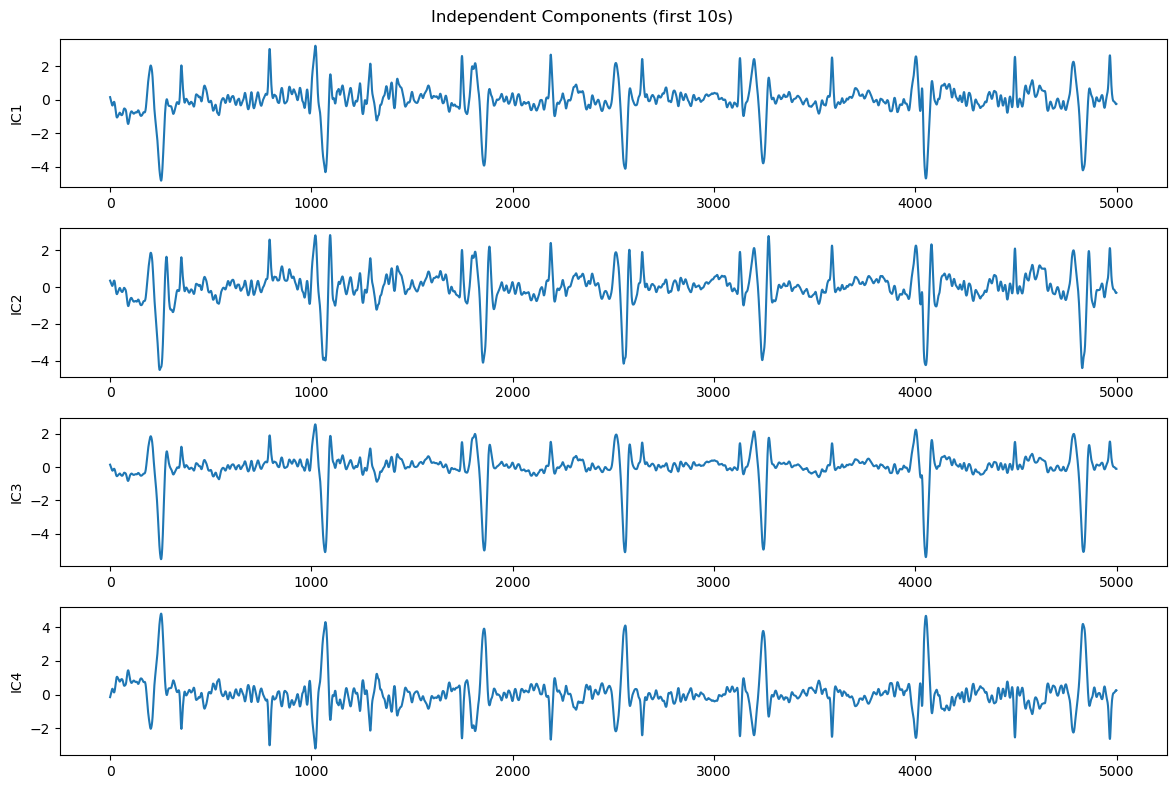

In [47]:
signals_no_nan = pd.DataFrame(filtered_signals).interpolate().fillna(0).values

stds = np.std(signals_no_nan, axis=0)

stds[stds == 0] = 1

signals_scaled = (signals_no_nan - np.mean(signals_no_nan, axis=0)) / stds

from sklearn.decomposition import FastICA

ica = FastICA(
    n_components=signals_scaled.shape[1],
    random_state=42,
    max_iter=2000,
    tol=1e-5
)

components = ica.fit_transform(signals_scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(components.shape[1]):
    plt.subplot(components.shape[1], 1, i+1)
    plt.plot(components[:5000, i])
    plt.ylabel(f"IC{i+1}")
plt.suptitle("Independent Components (first 10s)")
plt.tight_layout()
plt.show()



## 1. Load and Inspect Data
Download PhysioNet 2013 data from:
https://physionet.org/content/challenge-2013/1.0.0/

Each record typically includes:
- Multiple abdominal ECG channels
- (Optionally) maternal chest ECG
- Reference fetal QRS annotations

Example filename: `a01`
    

Loaded record a01 from set-a
Signal shape: (60000, 4) (samples x channels)
Sampling frequency: 1000 Hz
Number of channels: 4


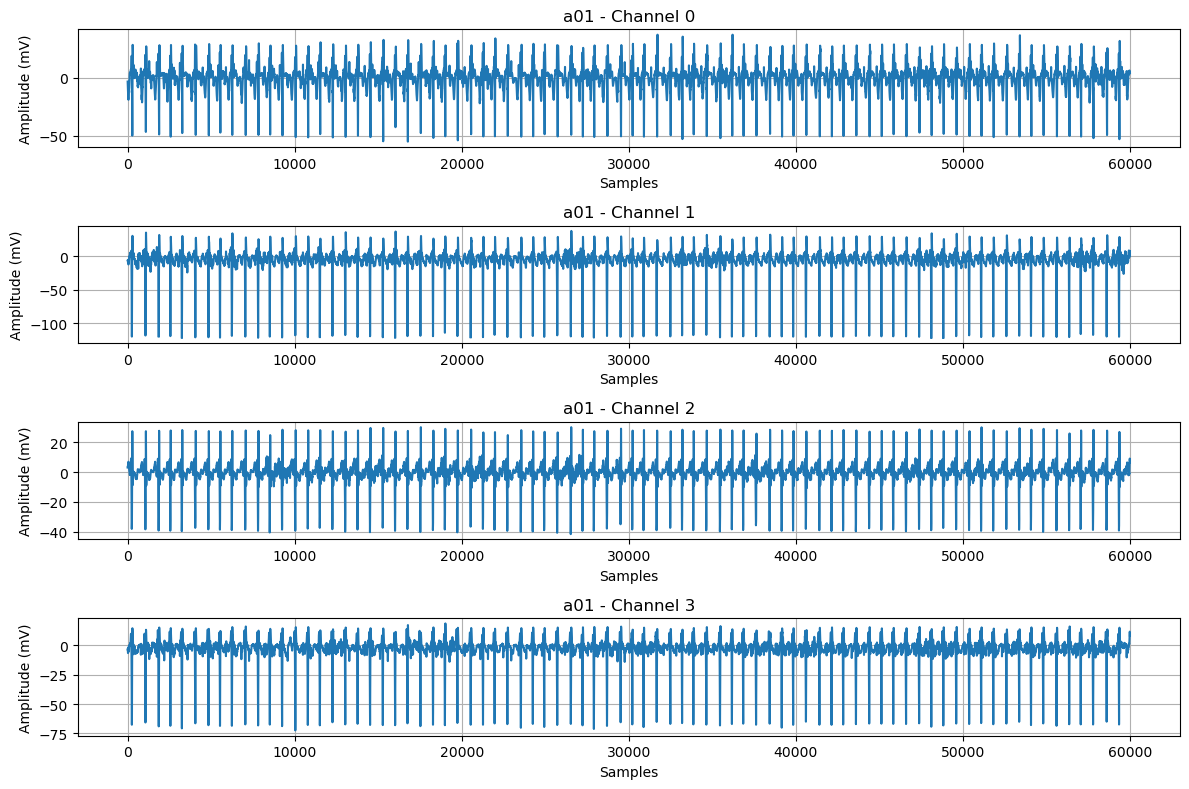

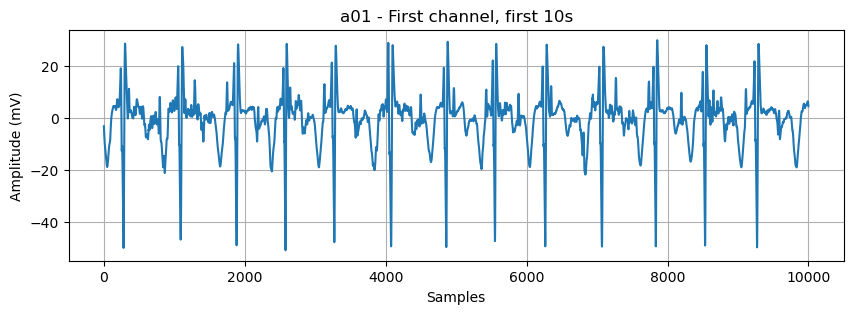

In [42]:
import matplotlib.pyplot as plt
import numpy as np

set_name = "set-a" 
record_idx = 0     

record_data = all_data[set_name][record_idx]
signals = record_data["samples"]
fs = record_data["record"].fs
record_name = record_data["name"]


samples_to_plot = int(10 * fs)  

print(f"Loaded record {record_name} from {set_name}")
print(f"Signal shape: {signals.shape} (samples x channels)")
print(f"Sampling frequency: {fs} Hz")
print(f"Number of channels: {signals.shape[1]}")

num_channels = signals.shape[1]

plt.figure(figsize=(12, 2*num_channels))
for ch in range(num_channels):
    plt.subplot(num_channels, 1, ch+1)
    plt.plot(signals[:, ch])
    plt.title(f"{record_name} - Channel {ch}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(signals[:samples_to_plot, 0])
plt.title(f"{record_name} - First channel, first 10s")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()



## 2. Preprocessing Filters
Remove:
- DC drift (high-pass filter at 0.5 Hz)
- Powerline interference (notch at 50/60 Hz)
Optionally bandpass around 1–100 Hz for ECG.
    

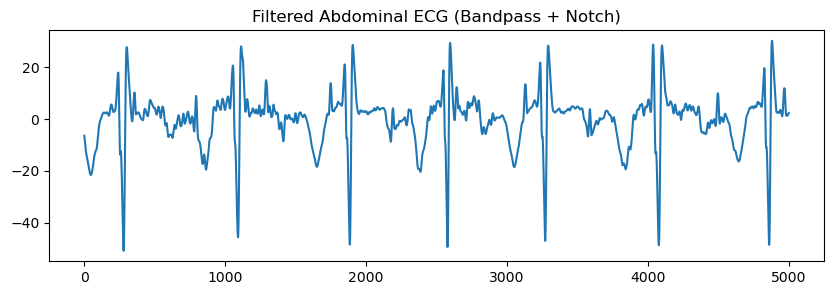

In [49]:

def bandpass_filter(signal, fs, lowcut=0.5, highcut=100.0):
    b, a = butter(4, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, freq=50.0, Q=30.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal)

filtered_signals = np.zeros_like(signals)
for ch in range(signals.shape[1]):
    temp = notch_filter(signals[:, ch], fs)
    temp = bandpass_filter(temp, fs)
    filtered_signals[:, ch] = temp

plt.figure(figsize=(10,3))
plt.plot(filtered_signals[:5000,0])
plt.title("Filtered Abdominal ECG (Bandpass + Notch)")
plt.show()
    


## 3. Maternal ECG Cancellation
We use **Independent Component Analysis (ICA)** to separate maternal and fetal sources.
ICA decomposes mixed abdominal channels into statistically independent components.
    

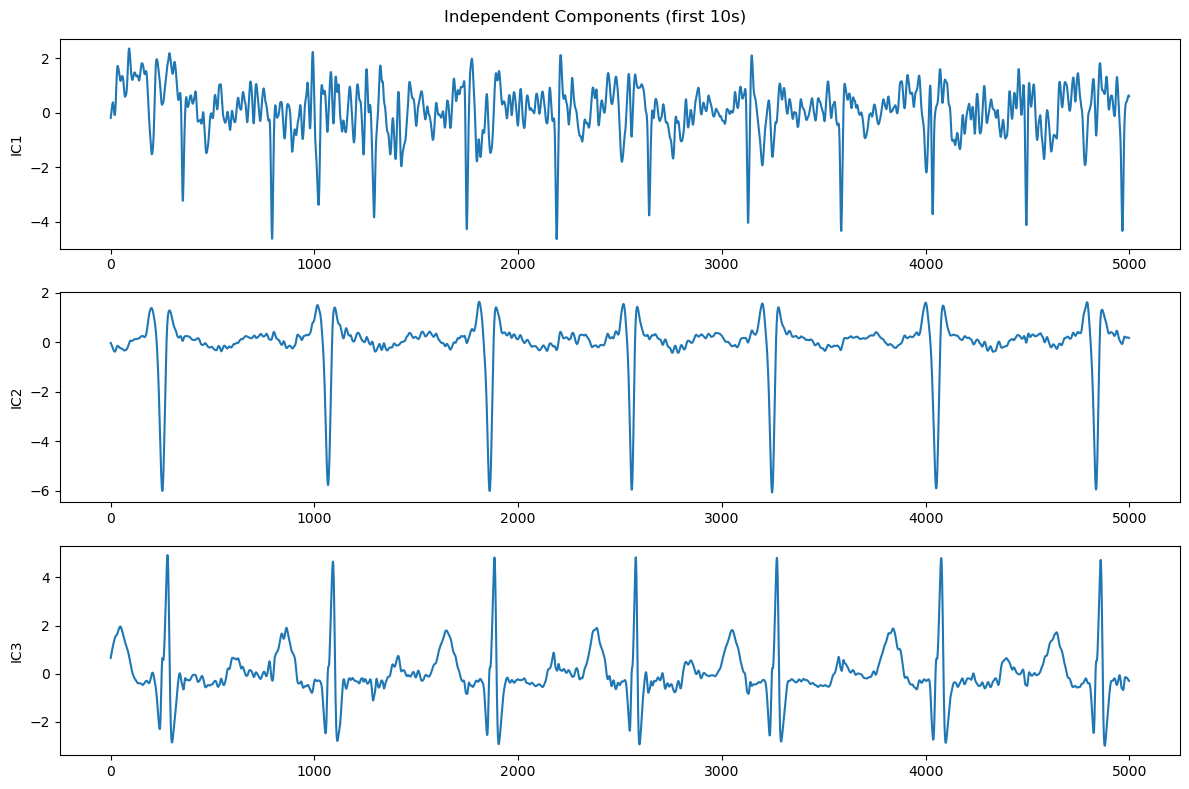

Identified maternal ICs: [2]


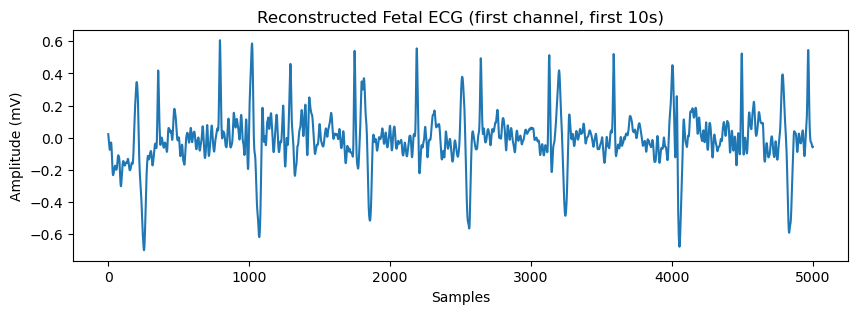

In [50]:

import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

signals_no_nan = pd.DataFrame(filtered_signals).interpolate().fillna(0).values


nonzero_var_idx = np.std(signals_no_nan, axis=0) > 0
signals_clean = signals_no_nan[:, nonzero_var_idx]


signals_scaled = (signals_clean - np.mean(signals_clean, axis=0)) / np.std(signals_clean, axis=0)

ica = FastICA(
    n_components=signals_scaled.shape[1],
    random_state=42,
    max_iter=1000,
    tol=1e-5
)
components = ica.fit_transform(signals_scaled)

plt.figure(figsize=(12, 8))
for i in range(components.shape[1]):
    plt.subplot(components.shape[1], 1, i+1)
    plt.plot(components[:5000, i])
    plt.ylabel(f"IC{i+1}")
plt.suptitle("Independent Components (first 10s)")
plt.tight_layout()
plt.show()

maternal_channel = filtered_signals[:, 0]  
corrs = np.corrcoef(components.T, maternal_channel)[-1, :-1]  
maternal_ics = np.where(np.abs(corrs) > 0.5)[0]  


print("Identified maternal ICs:", maternal_ics)

components_clean = components.copy()
components_clean[:, maternal_ics] = 0  

fetal_signals = ica.mixing_ @ components_clean.T
fetal_signals = fetal_signals.T


plt.figure(figsize=(10,3))
plt.plot(fetal_signals[:5000, 0])
plt.title("Reconstructed Fetal ECG (first channel, first 10s)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.show()




## 4. Fetal Component Selection and Denoising
We assume one or more components contain fetal ECG information.
We'll apply **wavelet denoising** to enhance fetal QRS morphology.
    

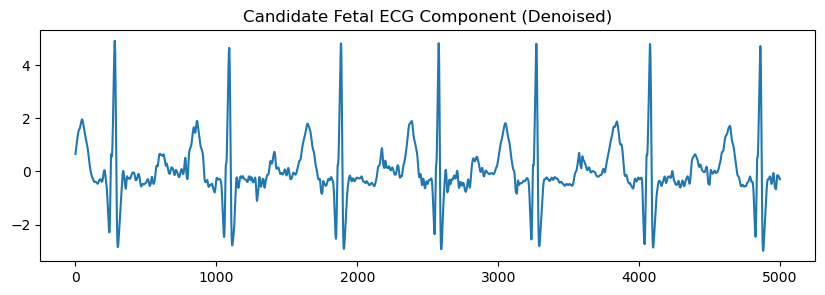

In [51]:

def wavelet_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Pick one IC manually for demonstration
fetal_ic = components[:, -1]
fetal_denoised = wavelet_denoise(fetal_ic)

plt.figure(figsize=(10,3))
plt.plot(fetal_denoised[:5000])
plt.title("Candidate Fetal ECG Component (Denoised)")
plt.show()
    


## 5. Fetal R-Peak Detection
Use peak finding on the denoised fetal ECG signal.
Compute Fetal Heart Rate (FHR) in beats per minute (BPM).
    

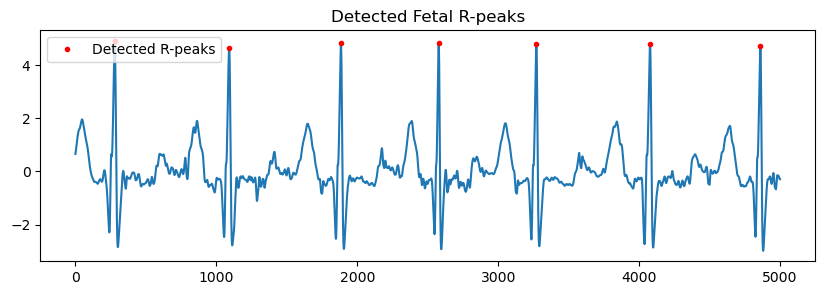

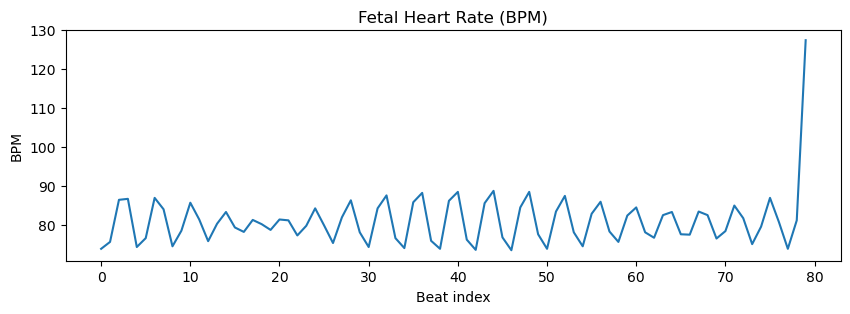

In [52]:

peaks, _ = find_peaks(fetal_denoised, distance=fs*0.3, height=np.std(fetal_denoised))
rr_intervals = np.diff(peaks) / fs
fhr = 60.0 / rr_intervals

plt.figure(figsize=(10,3))
plt.plot(fetal_denoised[:5000])
plt.plot(peaks[peaks < 5000], fetal_denoised[peaks[peaks < 5000]], 'r.', label='Detected R-peaks')
plt.legend()
plt.title("Detected Fetal R-peaks")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(fhr)
plt.title("Fetal Heart Rate (BPM)")
plt.xlabel("Beat index")
plt.ylabel("BPM")
plt.show()
    


## 6. Summary
- Loaded multichannel abdominal ECG from PhysioNet  
- Applied filtering (bandpass + notch)  
- Suppressed maternal ECG via ICA  
- Enhanced fetal ECG with wavelet denoising  
- Detected fetal R-peaks and computed FHR

✅ **Deliverables:**
- Raw vs filtered ECG plots  
- R-peaks on filtered fetal ECG  
- FHR trend plot
    